In [19]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Estimator, Sampler
from qiskit_aer.noise import NoiseModel

from squlearn import Executor
from squlearn.encoding_circuit import QiskitEncodingCircuit
from squlearn.observables import SinglePauli
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import Adam, SLSQP, SGLBO

import matplotlib.pyplot as plt
import matplotlib as mpl

from squlearn.optimizers.approximated_gradients import FiniteDiffGradient

In [ ]:
nqubits = 4

qc = QuantumCircuit(4)
p = ParameterVector('p', 8)
x = ParameterVector('x', 1)

p2 = np.array([-0.13005136, -1.34331017,  2.44392299, 1.64405423, -0.36315523, 0.45344925,
  0.18577077, -0.13904446])

qc.rx(1*np.arccos(x[0]), 0)
qc.rx(2*np.arccos(x[0]), 1)
qc.rx(3*np.arccos(x[0]), 2)
qc.rx(4*np.arccos(x[0]), 3)

qc.ry(p[0], 0)
qc.ry(p2[1], 1)
qc.ry(p2[2], 2)
qc.ry(p2[3], 3)

qc.cx(0, 1)
qc.cx(2, 3)
qc.cx(1, 2)
qc.cx(3, 0)

qc.rx(1*np.arccos(x[0]), 0)
qc.rx(2*np.arccos(x[0]), 1)
qc.rx(3*np.arccos(x[0]), 2)
qc.rx(4*np.arccos(x[0]), 3)

qc.ry(p2[4], 0)
qc.ry(p2[5], 1)
qc.ry(p2[6], 2)
qc.ry(p2[7], 3)

qc.cx(0, 1)
qc.cx(2, 3)
qc.cx(1, 2)
qc.cx(3, 0)


pqc = QiskitEncodingCircuit(qc)
pqc.draw()

In [ ]:
op = SinglePauli(nqubits,qubit=0,parameterized=True)
print(op)

In [ ]:
op.num_parameters

In [ ]:
# Randomly initialize parameters of the encoding circuit
np.random.seed(125) #13
param_ini =  np.random.rand(pqc.num_parameters)
# Initialize parameters of the observable as ones
param_op_ini = np.ones(op.num_parameters)
x0 = [[i * 0.2] for i in range(15)]
optimizer_options = {"bo_aqc_func": "EI", "bo_aqc_optimizer": "lbfgs", "bo_bounds": [(0.0, 5.0)], "log_file": "sglbo_noiseless.log",
                     "bo_n_calls": 30, "bo_x0_points": x0, "maxiter": 40}

qnn_simulator = QNNRegressor(
    pqc,
    op,
    Executor("statevector_simulator"),
    SquaredLoss(),
    SGLBO(optimizer_options),
    #SLSQP(),
    #Adam({"lr": 0.2,"log_file": "adam_noiseless.log"}),
    param_ini,
    param_op_ini=param_op_ini,
    opt_param_op=True, # Keine Observablen optimierung
    parameter_seed=124
)

In [ ]:
print(param_ini)
print(param_op_ini)

In [ ]:
# Data that is inputted to the QNN
x_train = np.arange(-0.5, 0.6, 0.1)
# Data that is fitted by the QNN
y_train = np.sin(6.0*x_train)

In [ ]:
def evaluate_loss(theta, qnn_regressor: QNNRegressor, X, y):
    param = theta[: qnn_regressor._qnn.num_parameters]
    param_op = theta[qnn_regressor._qnn.num_parameters :]

    loss_values = qnn_regressor._qnn.evaluate(qnn_regressor.loss.loss_args_tuple, X, param, param_op)

    loss_value = qnn_regressor.loss.value(
        loss_values,
        ground_truth=y,
        weights=np.ones(len(y)),
        iteration=0,
    )

    return loss_value




In [ ]:
qnn_simulator.fit(x_train, y_train)

In [ ]:
qnn_simulator.param

In [ ]:
qnn_simulator.param_op

In [ ]:
evaluate_loss([qnn_simulator.param,qnn_simulator.param_op], qnn_simulator, x_train, y_train)

In [22]:
def eval_loss_func(theta):
    return evaluate_loss(theta, qnn_simulator, x_train, y_train)

In [23]:
optimization_data = np.loadtxt("sglbo_noiseless_params2.log")
gradient_data = np.loadtxt("sglbo_noiseless_gradient2.log")
optimization_x = optimization_data[:, 0]
optimization_y = optimization_data[:, 1]
gradient_x = gradient_data[:, 0]
gradient_y = gradient_data[:, 1]




grad = FiniteDiffGradient(eval_loss_func, eps=0.05).gradient(optimization_data[0])
print("grad diff",grad)

print("gradient_data",gradient_data[0])

grad diff [ 0.19472352 -1.00139971]
gradient_data [ 0.19480586 -1.00139971]


In [ ]:
x = np.arange(np.min(x_train), np.max(x_train) + 0.01, 0.01)
y = qnn_simulator.predict(x)  # function for evaluating the prediction of the QNN
plt.plot(x, np.sin(6.0*x), label="Parabola function")
plt.plot(x, y, label="QNN inference")
plt.plot(x_train, y_train, "x", label="training data")
plt.legend()
plt.title("QNN inference of a parabola function")
plt.show()

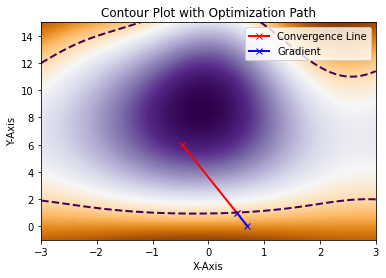

In [31]:
# Lese die Optimierungskoordinaten aus der Datei "params.log"
optimization_data = np.loadtxt("sglbo_noiseless_params2.log")
gradient_data = np.loadtxt("sglbo_noiseless_gradient2.log")
optimization_x = optimization_data[:, 0]
optimization_y = optimization_data[:, 1]
gradient_x = gradient_data[:, 0]
gradient_y = gradient_data[:, 1]

# plot the decision function for each datapoint on the grid
xx, yy = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-1, 15, 100))
Z = []
for i in range(len(xx)):
    for j in range(len(xx[i])):
        param = np.array([xx[i][j], yy[i][j]])
        Z.append(evaluate_loss(param, qnn_simulator, x_train, y_train))

Z = np.array(Z)
Z = Z.reshape(xx.shape)
#norm = mpl.colors.Normalize(vmin=-max(abs(np.min(Z)),abs(np.max(Z))), vmax=max(abs(np.min(Z)),abs(np.max(Z))))
im = plt.imshow(
    Z,
    interpolation="bilinear",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect="auto",
    origin="lower",
    cmap=plt.cm.PuOr_r,
    #norm=norm
)

# Verbinde die Punkte im Scatter Plot mit einer Linie
plt.plot(optimization_y[0:2],optimization_x[0:2],  '-x',c='red',  linewidth=2, label='Convergence Line')
plt.plot([optimization_y[0],optimization_y[0]+gradient_y[0]],[optimization_x[0],optimization_x[0]+gradient_x[0]], '-x',c='blue',  linewidth=2, label='Gradient')

plt.axis([-3, 3, -1, 15])

# Plot backtransformed hyperplane
contours = plt.contour(xx, yy, Z, levels=[eval_loss_func(optimization_data[0])], linewidths=2, linestyles="dashed")

# Plot training data

plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
plt.title('Contour Plot with Optimization Path')
plt.legend()
plt.show()